# Review Rating Prediction using Keras and Word Sequence Embeddings

In [1]:
# Install dependencies. You only have to run this once per notebook.
!pip install tensorflow numpy pandas matplotlib seaborn scikit-learn tensorflow-hub PyDrive --quiet
!python -V

Python 2.7.14


In [0]:
# Import dependencies
from __future__ import print_function

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

%matplotlib inline

# Reduce tf logging
tf.logging.set_verbosity(tf.logging.WARN)

# Don't use scientific notation when printing numpy.array values
np.set_printoptions(suppress=True)

# Use the cool looking seaborn style
sns.set_style("darkgrid")

## Download the data from Google Drive

In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID
file_id = '1fjR28PKqhdhTawVFIu7RX_6Z10Qhlekb'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("/tmp/one_million_reviews.csv")

In [0]:
# Load the recently downloaded file
dataset = "/tmp/one_million_reviews.csv"

def load_and_preprocess_data(dataset, num_examples=None, test_size=0.25):
    # Read data with pandas
    df, text, labels = None, None, None
    if num_examples is not None:
      df = pd.read_csv(dataset, 
                       usecols=['text', 'stars'], 
                       nrows=num_examples)
      text, labels = df['text'], df['stars']
    else:
      df = pd.read_csv(dataset, usecols=['text', 'stars'])
      text, labels = df['text'], df['stars']

    # Convert data into np.arrays
    text = np.array(text, dtype=np.str)[:, np.newaxis]

    # Bin labels into three categories
    # (0) -> 1-2, (1) -> 3, (2) -> 4-5
    bins = [0, 2, 3, 5]
    bin_labels = [0, 1, 2]
    binned_labels = pd.cut(labels, bins=bins, labels=bin_labels)
    
    # Now convert labels into one-hot-encoded vectors
    labels = tf.keras.utils.to_categorical(binned_labels, num_classes=3)

    return train_test_split(text, labels, test_size=test_size)
 

In [0]:
# Load 8,000 examples from our dataset
text_train, text_test, labels_train, labels_test = load_and_preprocess_data(dataset, num_examples=8000)

## Define the Embedding Module

In [0]:
# Download and load the tensorflow_hub embedding module. This will take some time.
# Enable tf info logging if you want to see download progress.

embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/2", trainable=True)

# This will be used in a keras.layers.Lambda layer
def EmbeddingModel(x):
  # This function essentially `calls` the hub.Module and returns a 512-dimensional vector
  return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

## Define the Model

In [0]:
input_text = tf.keras.layers.Input(shape=(1,), dtype="string")
embedding = tf.keras.layers.Lambda(EmbeddingModel, output_shape=(512,))(input_text)
dense1 = tf.keras.layers.Dense(128, activation='relu')(embedding)
dropout1 = tf.keras.layers.Dropout(0.2)(dense1)
dense2 = tf.keras.layers.Dense(32, activation='relu')(dropout1)
dropout2 = tf.keras.layers.Dropout(0.5)(dense2)
pred = tf.keras.layers.Dense(3, activation='softmax')(dropout2)

model = tf.keras.Model(inputs=[input_text], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
# Show the model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total para

In [11]:
# Store the history so we can see it later
history = None

# Start a session and fit the model using the 8000 examples from before!
with tf.Session() as sess:
  # K.set_session(sess)
  sess.run([tf.global_variables_initializer(), tf.tables_initializer()])
  history = model.fit(text_train, labels_train,
                      validation_data=(text_test, labels_test), 
                      epochs=30, verbose=2)
  
  model.save_weights('/tmp/model.h5')

Train on 6000 samples, validate on 2000 samples
Epoch 1/30
 - 5s - loss: 0.8821 - acc: 0.6450 - val_loss: 0.8105 - val_acc: 0.6410
Epoch 2/30
 - 3s - loss: 0.8287 - acc: 0.6563 - val_loss: 0.7992 - val_acc: 0.6655
Epoch 3/30
 - 3s - loss: 0.8074 - acc: 0.6657 - val_loss: 0.7864 - val_acc: 0.6710
Epoch 4/30
 - 3s - loss: 0.7987 - acc: 0.6717 - val_loss: 0.7756 - val_acc: 0.6745
Epoch 5/30
 - 3s - loss: 0.7823 - acc: 0.6745 - val_loss: 0.7769 - val_acc: 0.6745
Epoch 6/30
 - 3s - loss: 0.7685 - acc: 0.6830 - val_loss: 0.7846 - val_acc: 0.6755
Epoch 7/30
 - 3s - loss: 0.7564 - acc: 0.6888 - val_loss: 0.7746 - val_acc: 0.6765
Epoch 8/30
 - 3s - loss: 0.7362 - acc: 0.6962 - val_loss: 0.7785 - val_acc: 0.6780
Epoch 9/30
 - 3s - loss: 0.7196 - acc: 0.7007 - val_loss: 0.7905 - val_acc: 0.6725
Epoch 10/30
 - 3s - loss: 0.6936 - acc: 0.7117 - val_loss: 0.7920 - val_acc: 0.6680
Epoch 11/30
 - 3s - loss: 0.6671 - acc: 0.7215 - val_loss: 0.7940 - val_acc: 0.6655
Epoch 12/30
 - 3s - loss: 0.6475 - ac

Hmm, fairly accurate results. What's going on though? The validation loss is *increasing*! Let's see if we can figure out what the model is doing.

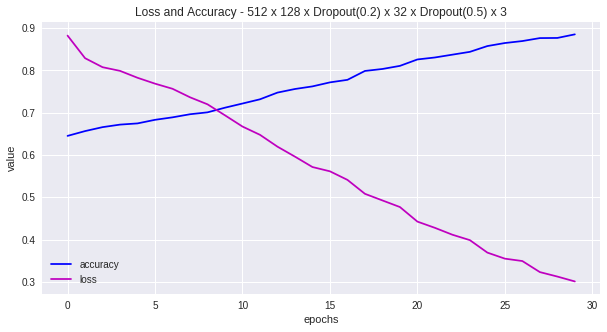

In [12]:
# Plot the accuracy and loss
plt.figure(figsize=(10,5))
plt.plot(history.history['acc'], c='b', label='accuracy')
plt.plot(history.history['loss'], c='m', label='loss')
plt.title("Loss and Accuracy - 512 x 128 x Dropout(0.2) x 32 x Dropout(0.5) x 3")
plt.xlabel('epochs'), plt.ylabel('value')
plt.legend()
plt.show()

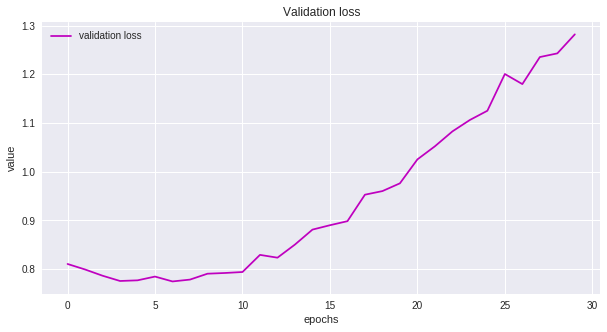

In [13]:
# Plot the validation loss
plt.figure(figsize=(10,5))
plt.plot(history.history['val_loss'], c='m', label='validation loss')
plt.title("Validation loss")
plt.xlabel('epochs')
plt.ylabel('value')
plt.legend()
plt.show()

Something is going horribly wrong with our model. Now loss should ever increase. 

The training loss decreased, but the validation loss is increasing. This probably indicates that our model is overfit to the training data.

## Test the Model with Custom Reviews

In [14]:
data = ["The food was absolutely disgusting! I will never return to this awful restaurant again.",
        "I love this place! The food was amazing and the staff were very friendly.",
        "This restaurant was pretty good. It was nothing unique, but the food was good enough that I will come back.",
       "I have never seen or used a worse product than this. I imagined I'd be able to actually type on the keyboard, but I guess not. Save yourself and don't purchase this keyboard."]

data = np.array(data, dtype=object)[:, np.newaxis]

with tf.Session() as sess:
  # K.set_session(sess)
  sess.run([tf.global_variables_initializer(), tf.tables_initializer()])
 
  model.load_weights('/tmp/model.h5')
  
  print( model.predict(data) )

[[0.9977925  0.0019062  0.00030135]
 [0.00025759 0.00662593 0.9931165 ]
 [0.0985999  0.7617444  0.13965574]
 [0.9994729  0.00003827 0.00048885]]


## Let's train with more data

In [0]:
# Load 50,000 examples from our dataset
text_train, text_test, labels_train, labels_test = load_and_preprocess_data(dataset, num_examples=50000)

In [0]:
# We should probably recreate the model to avoid influence from the previous training
input_text = tf.keras.layers.Input(shape=(1,), dtype="string")
embedding = tf.keras.layers.Lambda(EmbeddingModel, output_shape=(512,))(input_text)
dense1 = tf.keras.layers.Dense(128, activation='relu')(embedding)
dropout1 = tf.keras.layers.Dropout(0.2)(dense1)
dense2 = tf.keras.layers.Dense(32, activation='relu')(dropout1)
dropout2 = tf.keras.layers.Dropout(0.5)(dense2)
pred = tf.keras.layers.Dense(3, activation='softmax')(dropout2)

model = tf.keras.Model(inputs=[input_text], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
history = None

with tf.Session() as sess:
  sess.run([tf.global_variables_initializer(), tf.tables_initializer()])
  history = model.fit(text_train, labels_train,
                      validation_data=(text_test, labels_test), 
                      epochs=15, verbose=2)
  
  model.save_weights('/tmp/model.h5')

Train on 37500 samples, validate on 12500 samples
Epoch 1/15
 - 19s - loss: 0.7623 - acc: 0.6967 - val_loss: 0.7107 - val_acc: 0.7125
Epoch 2/15
 - 16s - loss: 0.7256 - acc: 0.7119 - val_loss: 0.6999 - val_acc: 0.7135
Epoch 3/15
 - 16s - loss: 0.7101 - acc: 0.7166 - val_loss: 0.7056 - val_acc: 0.7142
Epoch 4/15
 - 16s - loss: 0.7025 - acc: 0.7199 - val_loss: 0.6925 - val_acc: 0.7197
Epoch 5/15
 - 16s - loss: 0.6929 - acc: 0.7234 - val_loss: 0.6959 - val_acc: 0.7162
Epoch 6/15
 - 16s - loss: 0.6854 - acc: 0.7249 - val_loss: 0.6920 - val_acc: 0.7175
Epoch 7/15
 - 16s - loss: 0.6766 - acc: 0.7291 - val_loss: 0.6929 - val_acc: 0.7214
Epoch 8/15
 - 16s - loss: 0.6668 - acc: 0.7323 - val_loss: 0.6915 - val_acc: 0.7197
Epoch 9/15
 - 16s - loss: 0.6605 - acc: 0.7346 - val_loss: 0.6926 - val_acc: 0.7202
Epoch 10/15
 - 16s - loss: 0.6526 - acc: 0.7374 - val_loss: 0.6966 - val_acc: 0.7174
Epoch 11/15
 - 16s - loss: 0.6446 - acc: 0.7405 - val_loss: 0.7060 - val_acc: 0.7149
Epoch 12/15
 - 16s - los

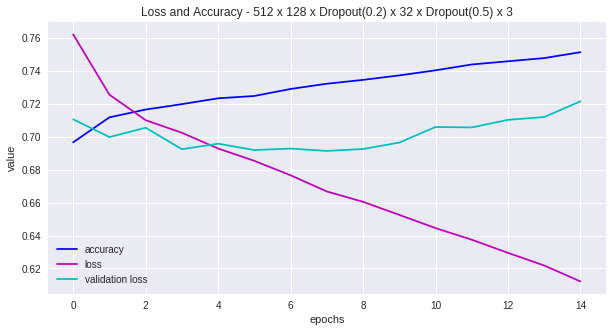

In [18]:
plt.figure(figsize=(10,5))
plt.plot(history.history['acc'], c='b', label='accuracy')
plt.plot(history.history['loss'], c='m', label='loss')
plt.plot(history.history['val_loss'], c='c', label='validation loss')
plt.title("Loss and Accuracy - 512 x 128 x Dropout(0.2) x 32 x Dropout(0.5) x 3")
plt.xlabel('epochs'), plt.ylabel('value')
plt.legend()
plt.show()

Our validation is still increasing slightly after around epoch 8. What's going on?